In [0]:
import fastai
import numpy as np 
import pandas as pd
import os, sys
from fastai import *
from fastai.vision import *

In [0]:
!unzip 'Data.zip'

In [0]:
PATH = Path('')
df_train = pd.read_csv(PATH/"train.csv") \
           .assign(filename = lambda df: "Data/train/" + df.Frame_ID)
df_test = pd.read_csv(PATH/"Test.csv") \
          .assign(filename = lambda df: "Data/test/" + df.Frame_ID)

In [97]:
df_train.head()

,Frame_ID,Emotion,filename
0,frame0.jpg,happy,Data/train/frame0.jpg
1,frame1.jpg,happy,Data/train/frame1.jpg
2,frame2.jpg,surprised,Data/train/frame2.jpg
3,frame3.jpg,surprised,Data/train/frame3.jpg
4,frame4.jpg,angry,Data/train/frame4.jpg


In [98]:
df_test.head()

,Frame_ID,filename
0,test0.jpg,Data/test/test0.jpg
1,test1.jpg,Data/test/test1.jpg
2,test2.jpg,Data/test/test2.jpg
3,test3.jpg,Data/test/test3.jpg
4,test4.jpg,Data/test/test4.jpg


In [0]:
transforms = get_transforms(
    do_flip = True,
    #flip_vert = True,
    max_zoom = 0.1,
    max_rotate = 45, 
    max_lighting = 0.3, 
    max_warp = 0.1
)

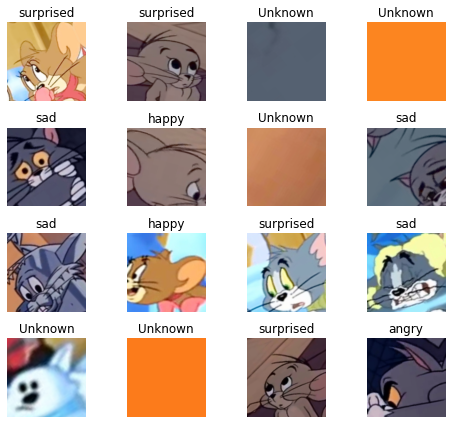

In [101]:
data = ImageDataBunch.from_df(path = "",
                              df = df_train,
                              fn_col = "filename",
                              label_col = "Emotion",
                              ds_tfms = transforms,
                              size=150,
                              #bs=2
                              )\
        .normalize(imagenet_stats)

data.show_batch(rows=4, figsize=(7,6))

In [0]:
kappa = KappaScore()
kappa.weights = "quadratic"
learn = cnn_learner(data, models.squeezenet1_1,
                    metrics=[error_rate, kappa])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.94E-03
Min loss divided by 10: 1.98E-02


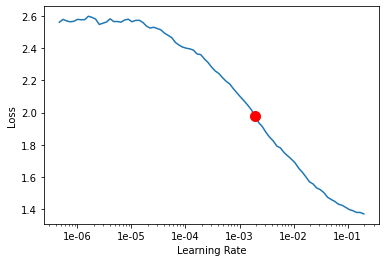

In [103]:
learn.lr_find(end_lr=0.5)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.371060,1.208578,0.271186,0.749866,00:01
1,0.383286,1.191632,0.271186,0.749866,00:01
2,0.351861,1.186113,0.271186,0.776554,00:01
3,0.371678,1.208543,0.254237,0.804451,00:01
4,0.360174,1.119277,0.220339,0.816056,00:01
5,0.352729,1.205992,0.288136,0.751545,00:01
6,0.325156,1.426457,0.288136,0.741508,00:01
7,0.311764,1.453452,0.305085,0.729582,00:01
8,0.316420,1.344071,0.271186,0.746055,00:01
9,0.335558,1.716525,0.271186,0.731992,00:01


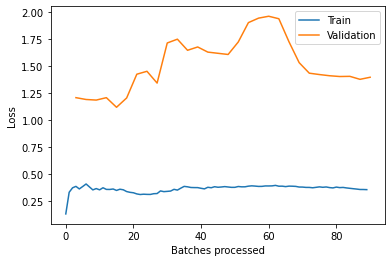

In [105]:
lr = 1.98E-02
learn.fit_one_cycle(30, lr)
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,error_rate,kappa_score,time
0,0.257299,1.397007,0.288136,0.749024,00:01
1,0.237822,1.540232,0.288136,0.742586,00:01
2,0.242513,1.587645,0.271186,0.787941,00:01
3,0.235110,1.778673,0.322034,0.710066,00:01
4,0.279423,2.199463,0.338983,0.720287,00:01
5,0.315129,2.055207,0.322034,0.644250,00:01
6,0.342429,2.645583,0.338983,0.695657,00:01
7,0.367229,1.588427,0.355932,0.732401,00:01
8,0.394917,2.955652,0.423729,0.704038,00:01
9,0.439617,3.589005,0.322034,0.711296,00:01


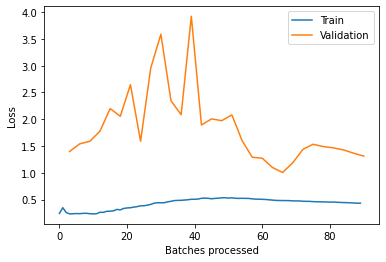

In [106]:
learn.unfreeze()
lrs = slice(lr/400,lr/4)
learn.fit_one_cycle(30,lrs)

learn.recorder.plot_losses()

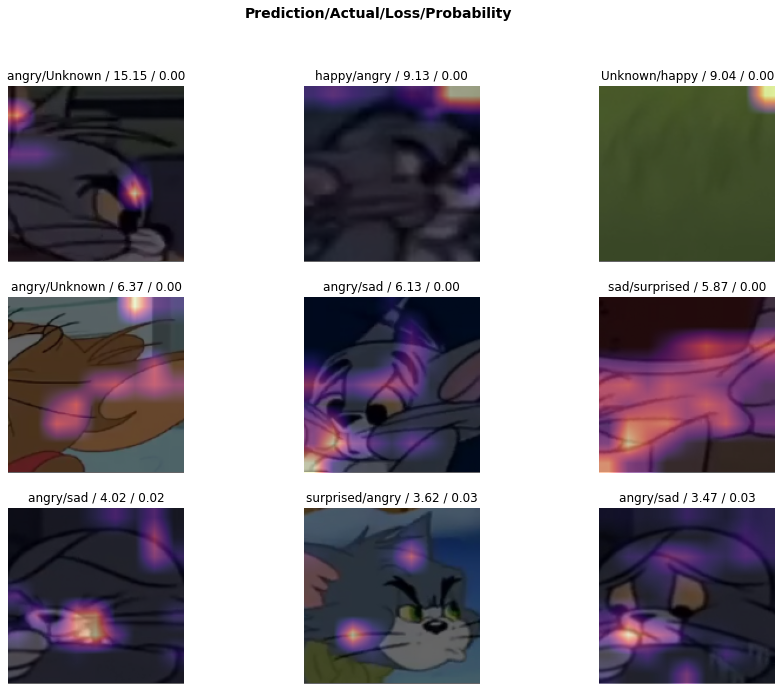

In [107]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

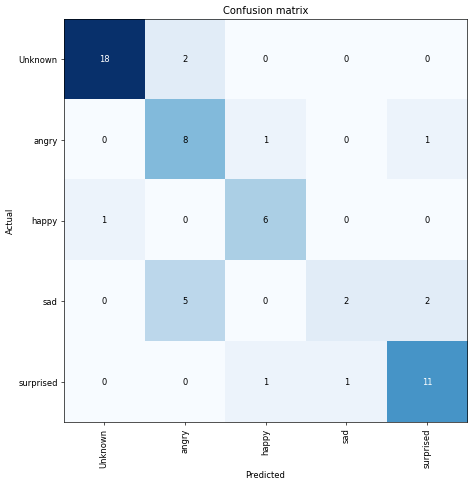

In [108]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [109]:
df_test['Emotion'] = 'pred'
df_test.head()

,Frame_ID,filename,Emotion
0,test0.jpg,Data/test/test0.jpg,pred
1,test1.jpg,Data/test/test1.jpg,pred
2,test2.jpg,Data/test/test2.jpg,pred
3,test3.jpg,Data/test/test3.jpg,pred
4,test4.jpg,Data/test/test4.jpg,pred


In [0]:
#------------------------------------------------------------
import shutil
shutil.rmtree('Data')

In [0]:
!unzip Dataset.zip

In [0]:
learn.data.add_test(ImageList.from_df(
    df_test, PATH,
    folder='Data/test',
    #suffix='.jpg'
))

In [113]:
preds,y = learn.get_preds(DatasetType.Test)
df_test['Emotion'] = preds.argmax(1)
df_test.head()

,Frame_ID,filename,Emotion
0,test0.jpg,Data/test/test0.jpg,4
1,test1.jpg,Data/test/test1.jpg,1
2,test2.jpg,Data/test/test2.jpg,0
3,test3.jpg,Data/test/test3.jpg,2
4,test4.jpg,Data/test/test4.jpg,1


In [114]:
dic = learn.data.c2i
mapp = {v: k for k, v in dic.items()}
mapp

{0: 'Unknown', 1: 'angry', 2: 'happy', 3: 'sad', 4: 'surprised'}

In [115]:
df_test.drop(['filename'], axis=1, inplace=True)
df_test.head()

,Frame_ID,Emotion
0,test0.jpg,4
1,test1.jpg,1
2,test2.jpg,0
3,test3.jpg,2
4,test4.jpg,1


In [116]:
submit = pd.DataFrame(columns=['Image', 'Emotion'])
submit

,Image,Emotion


In [117]:
for index, row in df_test.iterrows():
  row['Emotion'] = mapp.get(row.Emotion)
  submit[index] = row
  
  
submit.head()

,Image,Emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185
Frame_ID,NaN,NaN,test0.jpg,test1.jpg,test2.jpg,test3.jpg,test4.jpg,test5.jpg,test6.jpg,test7.jpg,test8.jpg,test9.jpg,test10.jpg,test11.jpg,test12.jpg,test13.jpg,test14.jpg,test15.jpg,test16.jpg,test17.jpg,test18.jpg,test19.jpg,test20.jpg,test21.jpg,test22.jpg,test23.jpg,test24.jpg,test25.jpg,test26.jpg,test27.jpg,test28.jpg,test29.jpg,test30.jpg,test31.jpg,test32.jpg,test33.jpg,test34.jpg,test35.jpg,test36.jpg,test37.jpg,...,test146.jpg,test147.jpg,test148.jpg,test149.jpg,test150.jpg,test151.jpg,test152.jpg,test153.jpg,test154.jpg,test155.jpg,test156.jpg,test157.jpg,test158.jpg,test159.jpg,test160.jpg,test161.jpg,test162.jpg,test163.jpg,test164.jpg,test165.jpg,test166.jpg,test167.jpg,test168.jpg,test169.jpg,test170.jpg,test171.jpg,test172.jpg,test173.jpg,test174.jpg,test175.jpg,test176.jpg,test177.jpg,test178.jpg,test179.jpg,test180.jpg,test181.jpg,test182.jpg,test183.jpg,test184.jpg,test185.jpg
Emotion,NaN,NaN,surprised,angry,Unknown,happy,angry,Unknown,Unknown,Unknown,surprised,surprised,surprised,surprised,angry,surprised,surprised,angry,surprised,happy,angry,angry,surprised,angry,angry,angry,angry,happy,surprised,surprised,Unknown,surprised,sad,sad,surprised,happy,surprised,Unknown,Unknown,Unknown,...,surprised,surprised,Unknown,angry,surprised,surprised,surprised,surprised,angry,angry,happy,happy,angry,angry,angry,surprised,angry,angry,happy,happy,happy,happy,happy,happy,happy,surprised,surprised,angry,angry,angry,angry,surprised,happy,Unknown,sad,sad,happy,angry,surprised,angry


In [118]:
submit = submit.T
submit.head()

,Frame_ID,Emotion
Image,NaN,NaN
Emotion,NaN,NaN
0,test0.jpg,surprised
1,test1.jpg,angry
2,test2.jpg,Unknown


In [119]:
submit.drop(['Image', 'Emotion'], axis=0, inplace=True)
submit.head()

,Frame_ID,Emotion
0,test0.jpg,surprised
1,test1.jpg,angry
2,test2.jpg,Unknown
3,test3.jpg,happy
4,test4.jpg,angry


In [0]:
submit.to_csv('submit_toon_mehnat0.csv', index=False)